## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [25]:
!pip3 install seaborn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

You should consider upgrading via the 'pip install --upgrade pip' command.


In [26]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv', usecols=columns)
df = df.fillna(0)
df.isnull().sum()

neighbourhood_group               0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [27]:
df = df.drop(df[df.price == 0].index)
df['price'] = np.log2(df['price'])



In [28]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [29]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [30]:
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [32]:
df_train.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Manhattan,40.70757,-74.00788,Entire home/apt,2,2,1.36,1,12
1,Brooklyn,40.69037,-73.92694,Private room,9,1,0.33,1,83
2,Queens,40.75665,-73.92015,Entire home/apt,30,15,0.19,8,268
3,Manhattan,40.74832,-73.98814,Entire home/apt,6,0,0.00,1,0
4,Manhattan,40.83310,-73.94007,Private room,3,0,0.00,1,89


In [33]:
train_dicts = df_train.to_dict(orient='records')


In [34]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)


## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [35]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [36]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [6.17]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [7.41]



/Users/ak381b/Documents/personal/learning/mlbookcamp-code/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [37]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [38]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [39]:
y_pred = rf.predict(X_val)

In [40]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_pred, y_val, squared=False)

In [41]:
rms

0.6818306772128904

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [44]:
runs = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rms = mean_squared_error(y_pred, y_val, squared=False)
    runs.append((n, rms))

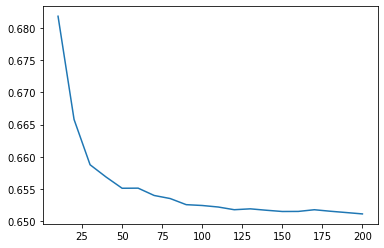

In [51]:
df_scores = pd.DataFrame(runs, columns=['n_estimators', 'rms'])
plt.plot(df_scores.n_estimators, df_scores.rms)
# plt.ylim( 0.650, 0.665)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [58]:
n_estimator = 70
scores = []
for d in [5, 10, 12, 15, 20, 25]:
    rf = RandomForestRegressor(n_estimators=n_estimator, random_state=1, n_jobs=-1, max_depth=d)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rms = mean_squared_error(y_pred, y_val, squared=False)
    scores.append((d, rms))

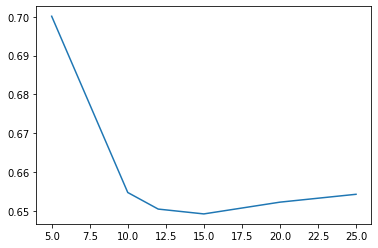

In [59]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'rms'])
plt.plot(df_scores.max_depth, df_scores.rms)

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

[7.94951940e-02 3.11347896e-02 1.45615430e-01 1.53397521e-01
 5.25508082e-02 2.87947948e-04 8.01761296e-04 3.51039948e-02
 1.00259586e-03 9.35936599e-05 4.30351638e-02 5.19156409e-02
 3.97019073e-01 4.11272944e-03 4.43375690e-03]


/Users/ak381b/Documents/personal/learning/mlbookcamp-code/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<BarContainer object of 15 artists>

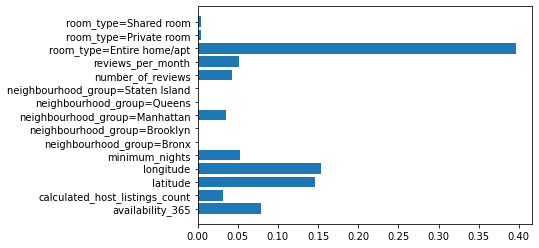

In [78]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1, max_depth=20)
rf.fit(X_train, y_train)


print(rf.feature_importances_)

plt.barh(dv.get_feature_names(), rf.feature_importances_)

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` first to `0.1` and then to `0.01`

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

